# CNN   small datasets 학습


- Data의 수가 많지 않을 때 CNN을 통한 모형 학습이 어려울 수 있음
  - 딥러닝은 많은 수의 데이터를 통해 feature engineering 과정 없이 feature를 찾을 수 있는데 있음 
- Data가 많지 않아 CNN 학습에 어려움이 있을 때 사용 가능한 방법
    - Data augmentation 활용
        - 이미지의 색깔, 각도 등을 약간씩 변형하여 data의 수를 늘림 
    - Pre-trained network의 활용
        - 매우 큰 데이터셋으로 미리 Training한 모델의 파라미터(가중치)를 가져와서 풀려는 문제에 맞게 모델을 재보정해서 사용하는 것.
        - 미리 다양한 데이터를 가지고 학습된 모델을 사용하므로 적은 데이터에도 좋은 성능을 낼 수있다.

## Data for cats vs. dogs
- 2013년 Kaggle의 computer vision competition data 활용 https://www.kaggle.com/c/dogs-vs-cats/data
- 개와 고양이를 구분하기 위한 문제로 각 12,500개의 이미지를 포함
- Medium-resolution color JPEGs
- 25000장의 사진 중 4000장의 cats/dogs 사진(2000 cats, 2000 dogs) 만을 사용하여 학습하여 좋은 모형을 만들어 낼 수 있을까?
    - 학습: 2000, 검증: 1000, 테스트: 1000
    
![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

- gdown 패키지 : 구글 드라이브의 공유파일 다운로드 패키지    
- `pip install gdown==3.3.1`
- 코랩에는 설치 되어 있음.

In [1]:
# 이미지 다운로드

import gdown

url = 'https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU'
fname = 'cats_and_dogs_small.zip'

gdown.download(url, fname, quiet=False)  #url, 저장할 경로

Downloading...
From: https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU
To: /content/cats_and_dogs_small.zip
90.8MB [00:01, 83.6MB/s]


'cats_and_dogs_small.zip'

In [2]:
# 리눅스 명령어로 디렉토리 생성
!mkdir data

In [3]:
# 압축 풀기  -q: 로그 남기지 않음, -d: 압축 풀 디렉토리
!unzip -q cats_and_dogs_small.zip -d data/cats_and_dogs_small

## Build a network

- Input: $150 \times 150$ 픽셀의 RGB layer 
- Output: cat or dog (binary classification) 
- ImageDataGenerator를 이용해 파일시스템에 저장된 이미지데이터셋을 학습시킨다.

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

np.random.seed(1)
tf.random.set_seed(1)

In [5]:
# 하이퍼파라미터
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.5
N_EPOCHS = 50
IMAGE_SIZE = 150
N_BATCHS = 20

In [6]:
def create_model():
    model = keras.Sequential()
    model.add(layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)))

    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPool2D(padding='same', ))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    model.add(layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    #classification
    model.add(layers.Flatten())
    model.add(layers.Dropout(DROPOUT_RATE))
    model.add(layers.Dense(units=512, activation='relu'))

    #출력
    model.add(layers.Dense(units=1, activation='sigmoid')) #dog/cat: binary classification

    return model


In [7]:
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [8]:
# ImageDataGenerator 생성 => Augmentation, 입력 pipeline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

train_dir = '/content/data/cats_and_dogs_small/train'
validation_dir = '/content/data/cats_and_dogs_small/validation'
test_dir = '/content/data/cats_and_dogs_small/test'

In [9]:
# 1. ImageDataGenerator - No Augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator (rescale=1./255)

In [10]:
# Gen.flow_from_directory() 이용해서 iterator 생성
train_iterator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                   class_mode='binary',
                                                   batch_size=N_BATCHS
                                                   )

validation_iterator = test_datagen.flow_from_directory(directory=validation_dir,
                                                       target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                       class_mode='binary',
                                                       batch_size=N_BATCHS
                                                       )

test_iterator = test_datagen.flow_from_directory(directory=test_dir,
                                                       target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                       class_mode='binary',
                                                       batch_size=N_BATCHS
                                                       )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
train_iterator.class_indices

{'cats': 0, 'dogs': 1}

In [12]:
len(train_iterator), len(validation_iterator), len(test_iterator)

(100, 50, 50)


##  Model Training(학습)

In [13]:
history = model.fit(train_iterator,
                    epochs=N_EPOCHS,
                    steps_per_epoch=len(train_iterator),
                    validation_data=validation_iterator,
                    validation_steps=len(validation_iterator))

Epoch 1/50
100/100 [==============================] - 43s 95ms/step - loss: 0.9428 - accuracy: 0.5283 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/50
100/100 [==============================] - 9s 91ms/step - loss: 0.6835 - accuracy: 0.5578 - val_loss: 0.6826 - val_accuracy: 0.5670
Epoch 3/50
100/100 [==============================] - 9s 91ms/step - loss: 0.6872 - accuracy: 0.6078 - val_loss: 0.6797 - val_accuracy: 0.5700
Epoch 4/50
100/100 [==============================] - 9s 91ms/step - loss: 0.5920 - accuracy: 0.6740 - val_loss: 0.6183 - val_accuracy: 0.6820
Epoch 5/50
100/100 [==============================] - 9s 91ms/step - loss: 0.5557 - accuracy: 0.7200 - val_loss: 0.5886 - val_accuracy: 0.6920
Epoch 6/50
100/100 [==============================] - 9s 91ms/step - loss: 0.4892 - accuracy: 0.7579 - val_loss: 0.5691 - val_accuracy: 0.7080
Epoch 7/50
100/100 [==============================] - 9s 91ms/step - loss: 0.4447 - accuracy: 0.7908 - val_loss: 0.6485 - val_accuracy: 0.671

In [14]:
model.evaluate(test_iterator)

50/50 [==============================] - 3s 56ms/step - loss: 2.1085 - accuracy: 0.7100


[2.108534812927246, 0.7099999785423279]

# Using data augmentation

- 학습 이미지의 수가 적어서 overfitting이 발생할 가능성을 줄이기 위해 기존 훈련 데이터로부터 그럴듯하게 이미지 변환을 통해서 이미지(데이터)를 늘리는 작업을 Image augmentation
- train_set에만 적용, validation, test set에는 적용하지 않는다. (rescaling만 한다.)

In [34]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   brightness_range=(0.3, 1.3),
                                   fill_mode='constant')

# validation, test용
test_datagen = ImageDataGenerator(rescale=1./255)


In [35]:
train_iterator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                   class_mode='binary',
                                                   batch_size=N_BATCHS)

validation_iterator = test_datagen.flow_from_directory(validation_dir,
                                                       target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                       class_mode='binary',
                                                       batch_size=N_BATCHS)

test_iterator = train_datagen.flow_from_directory(test_dir,
                                                  target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                   class_mode='binary',
                                                   batch_size=N_BATCHS)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
# 이미지 확인
batch_image = train_iterator.next()
batch_image[0].shape, batch_image[1]

((20, 150, 150, 3),
 array([1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 1.], dtype=float32))

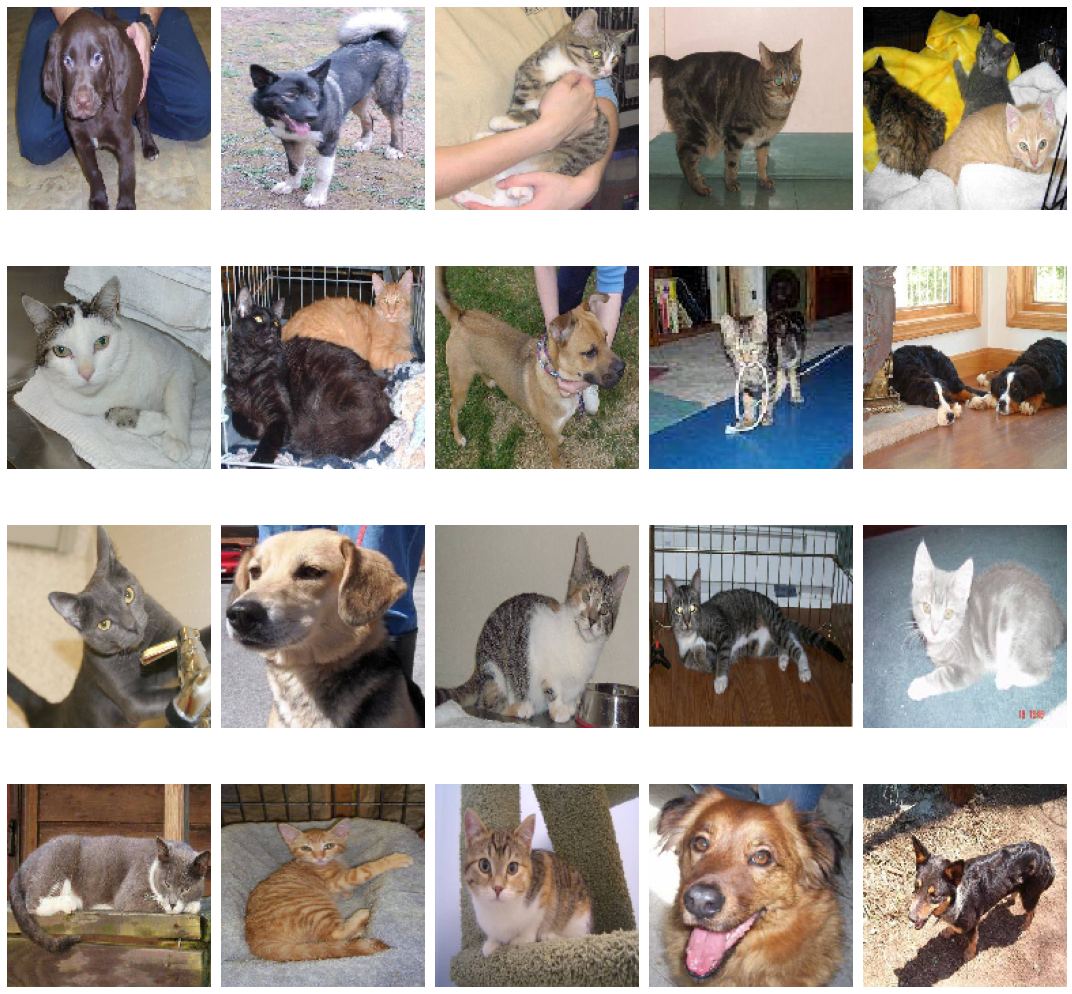

In [22]:
plt.figure(figsize=(15,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(batch_image[0][i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [36]:
model2 = create_model()
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                                               loss='binary_crossentropy',
                                               metrics=['accuracy'])


In [37]:
model2.fit(train_iterator,
           epochs=N_EPOCHS,
           steps_per_epoch=len(train_iterator),
           validation_data=validation_iterator,
           validation_steps=len(validation_iterator))

Epoch 1/50
100/100 [==============================] - 19s 188ms/step - loss: 0.9212 - accuracy: 0.5100 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/50
100/100 [==============================] - 19s 186ms/step - loss: 0.6937 - accuracy: 0.4767 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/50
100/100 [==============================] - 19s 185ms/step - loss: 0.6931 - accuracy: 0.5137 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/50
100/100 [==============================] - 19s 185ms/step - loss: 0.6936 - accuracy: 0.5085 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/50
100/100 [==============================] - 18s 185ms/step - loss: 0.6932 - accuracy: 0.5096 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/50
100/100 [==============================] - 18s 185ms/step - loss: 0.6931 - accuracy: 0.5069 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/50
100/100 [==============================] - 19s 188ms/step - loss: 0.6931 - accuracy: 0.5115 - val_loss: 0.6931 - val_ac

###  DataFrame 이용
- flow_from_dataframe() 사용
    - 파일경로와 label을 DataFrame으로 저장하고 그것을 이용해 데이터셋을 읽어온다.